<a id = 'top'></a>

[Configure Notebook](#configure)  
***

# Cross-trial SNR checks by cell  
###### For each ROI Plot average displacement normalized to roi radius as mask.

We find a representative trial where we know the cell is well represented by its mask. We then assume that any FOV displacement will cause the local neighborhood around the mask to shift uniformly. If the cell doesn’t move under the mask, then we should be able to reliably identify it in the local neighborhood across the experiment. To quantify displacement, we can cross correlate the small representative mask to its larger neighborhood across time.  Periods where the displacement between correlation peaks is greater than half the mask diameter can be isolated and excluded.

 
>[Calculate SNR for each ROI](#calculate)  
>[Plot](#plot)  




##### Set paths 


In [180]:
maskPath = '/Users/Stan/Desktop/sp112315a_h5/sp112315a_mask.dat'
experiment = 'sp112315a'
sframePath = '/Users/Stan/Desktop/sp112315a_h5/traces/sp112315a_processed'
rawTraces_e1_Path = '/Users/Stan/Desktop/sp112315a_h5/traces/tracesDicts/e1_traces_dict.dat'
rawTraces_e2_Path = '/Users/Stan/Desktop/sp112315a_h5/traces/tracesDicts/e2_traces_dict.dat'
workflowDict_e1_Path = '/Users/Stan/Desktop/sp112315a_h5/traces/tracesDicts/workflow_dict_e1.dat'
workflowDict_e2_Path = '/Users/Stan/Desktop/sp112315a_h5/traces/tracesDicts/workflow_dict_e2.dat'

##### save/load

In [4]:
workflow_dict = pickle.load(open(workflowDict_e1_Path))

In [181]:
mask = pickle.load(open(maskPath))

<a id = 'calculate'></a>
##### SNR

[back to top](#top)

In [46]:
from spUtils.get_normalized_traces_submodule import getMaxEvents
from spUtils import getSNR

traces = next(spUtils.gen_dict_extract('corrected_rois', workflow_dict))
numCells = workflow_dict['numCells']
events = workflow_dict['events']['pos_events']

maxEvents = getMaxEvents(events,traces)
numCells, numTrials = maxEvents.shape[1:]

In [63]:
from collections import defaultdict
#baselined1 traces
allSNRs = defaultdict(list)

for cell in range(numCells): 
    for trial in range(numTrials):
        allSNRs[cell].append(_getSNR(traces,maxEvents,cell,trial))
    allSNRs[cell]=list(np.hstack(allSNRs[cell]))
#'SNR_awake.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

In [109]:
maxEventNum = max(len(allSNRs[cell]) for cell in range(numCells))
df = pd.DataFrame(pd.Series(allSNRs[0]), index = range(maxEventNum))
for cell in range(numCells)[1:]:
    df[cell]= pd.Series(allSNRs[cell])
mean = pd.DataFrame(df.mean(axis = 0))
mean.rename(columns ={0:'mean'}, inplace=True)
mean.index.rename('cellID', inplace=True)

<a id = 'plot'></a>
##### Plot

[back to top](#top)

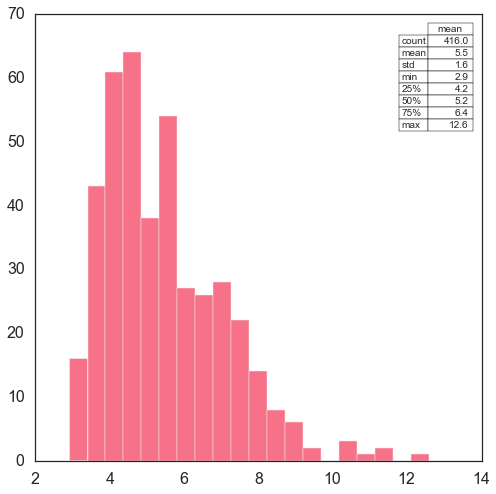

In [343]:
#Show distribution
b = pd.DataFrame(mean['mean']).describe()
f,(ax1) = plt.subplots(1,1, figsize = (8,8))
ax1.hist(mean['mean'], bins = 20)
table(ax1, np.round(b, 1),loc='upper right', colWidths=[0.1])

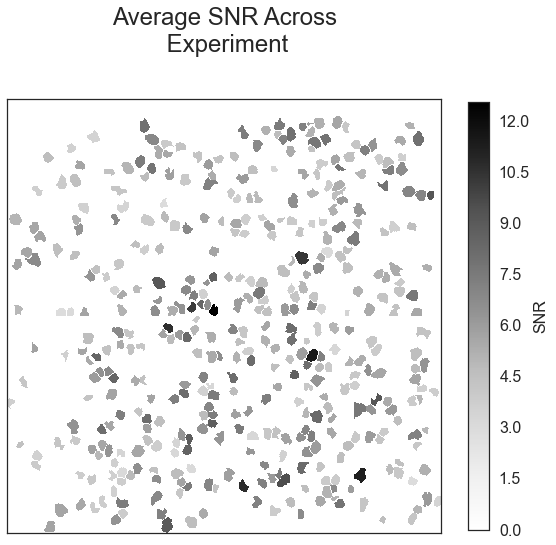

In [339]:

f,ax1 = plt.subplots(1,1, figsize = (8,8))
#f.suptitle('Average SNR Across \n Experiment', fontsize=24, x=.5, y=1.2)

masktoPlot = np.zeros_like(mask).astype(float)
for cellID,meanVal in mean.values[1:]:#exclude background
    masktoPlot[mask==cellID]=meanVal
    
#plot and format each plot
image = ax1.imshow(masktoPlot)
image.axes.get_xaxis().set_visible(False)
image.axes.get_yaxis().set_visible(False)
ax1.set_title('Average SNR Across \n Experiment', fontsize = 24, y = 1.1)

from pandas.tools.plotting import table
cbar = plt.colorbar(image, shrink = 0.83)
cbar.set_label('SNR', fontsize = 16)
#cb = fig.colorbar(quadmesh,ax=ax, shrink=.5, pad=.2, aspect=10)
plt.tight_layout()

plt.savefig('/users/stan/desktop/corrPlots/SNRmask.png',bbox_inches='tight', pad_inches=0.5 )

<a id = 'top'></a>
##### Configure 

[back to top](#top)  

In [2]:
import sys
sys.path.append('/users/stan/documents/')
import os
from glob import glob
import copy
import pandas
import numpy as np

from d_code.imaging.io import tifffile
import matplotlib.pylab as plt
from joblib import Parallel, delayed
from collections import defaultdict
from scipy import signal
from time import time
import cPickle as pickle
import spUtils
import seaborn as sns


import graphlab as gl
gl.canvas.set_target('ipynb')
import pandas as pd

sns.set_palette("husl")
sns.set_style("white")
sns.set_context("poster")


%matplotlib inline

#style notebook
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

A newer version of GraphLab Create (v1.8.4) is available! Your current version is v1.8.1.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.
[INFO] This non-commercial license of GraphLab Create is assigned to stanlp86@gmail.com and will expire on October 28, 2016. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-23664 - Server binary: /Users/Stan/anaconda/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1458086895.log
[INFO] GraphLab Server Version: 1.8.1
